# Анализ поведения пользователей мобильного приложения

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

<a id='content'></a>
## Оглавление

### Открытие и предобработка данных 
* [Загрузка датасета и проверка его на наличие дубликатов, пропусков и соответствие типам данных, а также правильность выгрузки](#start)

### Изучение и проверка данных
* [Сколько всего событий в логе? Сколько всего пользователей в логе? Сколько в среднем событий приходится на пользователя?](#part_1.1)
* [Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Отбросим старые данные](#part_1.2)
* [Много ли событий и пользователей мы потеряли, отбросив старые данные?](#part_1.3)
* [Вывод](#part_1.4)

### Воронка событий
* [Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируйем события по частоте.](#part_2.1)
* [Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.](#part_2.2)
* [Предположим, в каком порядке происходят события.](#part_2.3)
* [По воронке событий посчитем, какая доля пользователей проходит на следующий шаг воронки](#part_2.4)
* [На каком шаге теряете больше всего пользователей?](#part_2.5)
* [Какая доля пользователей доходит от первого события до оплаты?](#part_2.6)

### Результаты эксперимента
* [Сколько пользователей в каждой экспериментальной группе](#part_3.1)
* [Проверим, находят ли статистические критерии разницу между выборками 246 и 247.](#part_3.2)
* [Проверим, находят ли статистические критерии разницу между выборками 246 и 248.](#part_3.3)
* [Проверим, находят ли статистические критерии разницу между выборками 247 и 248.](#part_3.4)

### Вывод
* [Сделаем общий вывод и решим, какой шрифт лучше](#finish)


# Открытие и предобработка данных 
<a id='start'></a>
Загрузка датасета и проверка его на наличие дубликатов, пропусков и соответствие типам данных, а также правильность выгрузки

[*Назад к оглавлению*](#content)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\s+')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
data.columns = ['event', 'id', 'event_time', 'experiment']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event         244126 non-null object
id            244126 non-null int64
event_time    244126 non-null int64
experiment    244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Приведем дату к удобному формату, а также выделем в отдельные столбцы дату и время.

In [5]:
data['date_time'] = pd.to_datetime(data['event_time'], unit='s')
data['date'] = pd.DatetimeIndex(data['date_time']).date
data['time'] = pd.DatetimeIndex(data['date_time']).time
data.head()

,event,id,event_time,experiment,date_time,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,11:48:42


Посмотрим на наличие дубликатов и пропусков в данных.

In [6]:
data.duplicated().sum()

413

In [7]:
data.isnull().sum()

event         0
id            0
event_time    0
experiment    0
date_time     0
date          0
time          0
dtype: int64

Пропусков нет - это хорошо. Однако мы нашли 413 дублирующихся строк. Необходимо будет уточнить у коллег, действительно ли это ошибки или же особенности учета.

# Изучение и проверка данных

[*Назад к оглавлению*](#content)

Сколько всего событий в логе? Сколько всего пользователей в логе? Сколько в среднем событий приходится на пользователя? <a id='part_1.1'></a>

In [8]:
data['event'].count()

244126

In [9]:
data['id'].nunique()

7551

In [10]:
data.groupby('id').agg({'event': ['count']}).mean()

event  count    32.330287
dtype: float64

Мы имеем 244 126 событий совершенных 7 551 пользователями. В среднем на одного пользователя приходится 32,3 события.

Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. <a id='part_1.2'></a>

In [11]:
data['date'].min()

datetime.date(2019, 7, 25)

In [12]:
data['date'].max()

datetime.date(2019, 8, 7)

В нашем распоряжении данные с 25 июля 2019 года по 7 августа 2019 года.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


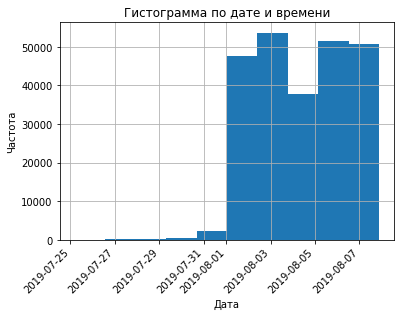

In [13]:
plt.hist(data['date_time'])
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.title('Гистограмма по дате и времени')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

Можно заметить, что полноценные данные мы имеем только начиная с 1 августа 2019 года. Отбросим остальные.

In [14]:
data_cut = data[(data['date'] > datetime.date(2019,7,31))]
data_cut.head()

,event,id,event_time,experiment,date_time,date,time
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,00:08:59


In [15]:
data_cut['date'].min()

datetime.date(2019, 8, 1)

In [16]:
data_cut['date'].max()

datetime.date(2019, 8, 7)

Много ли событий и пользователей мы потеряли, отбросив старые данные? <a id='part_1.3'></a>

In [17]:
data['event'].count() - data_cut['event'].count()

2828

In [18]:
len(data['id'].unique()) - len(data_cut['id'].unique())

17

Обрезав данные мы потеряли 2 828 событий и 17 уникальных пользователей, что составляет 1,16% и 0,23% от всего числа событий и пользователей соответвтенно.

Проверим, что у нас есть пользователи всех трех групп.

In [19]:
data_cut.groupby('experiment')['id'].count()

experiment
246    79425
247    77147
248    84726
Name: id, dtype: int64

<a id='part_1.4'></a>
В нашем распоряжении данные с 25 июля 2019 года по 7 августа 2019 года, однако полноценные данные мы имеем только начиная с 1 августа 2019 года.

Обрезав данные мы потеряли 2 828 событий и 17 уникальных пользователей, что составляет 1,16% и 0,23% от всего числа событий и пользователей соответвтенно.

Проверим, что у нас нет пользователей, попавших в несколько групп одновременно.

In [20]:
id_246 = data_cut.query('experiment == 246')['id']
id_247 = data_cut.query('experiment == 247')['id']
id_248 = data_cut.query('experiment == 248')['id']

In [21]:
print(len(data_cut.query('(experiment == 248) and id in @id_246')['id'].drop_duplicates()))
print(len(data_cut.query('(experiment == 248) and id in @id_247')['id'].drop_duplicates()))
print(len(data_cut.query('(experiment == 246) and id in @id_247')['id'].drop_duplicates()))

0
0
0


# Воронка событий

[*Назад к оглавлению*](#content)

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируйем события по частоте. <a id='part_2.1'></a>

In [22]:
data_cut.groupby('event')['id'].count().sort_values(ascending=False)

event
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: id, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие. <a id='part_2.2'></a>

In [23]:
data_user = data_cut.groupby('event').agg({'id': ['nunique']}).sort_values(by=('id','nunique'),
                                                               ascending=False)
data_user.columns = ['id_unique']
data_user['part'] = round(data_user['id_unique']/len(data_cut['id'].unique()), 2)
data_user

,id_unique,part
event,,
MainScreenAppear,7419,0.98
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.50
PaymentScreenSuccessful,3539,0.47
Tutorial,840,0.11


Предположим, в каком порядке происходят события. <a id='part_2.3'></a>

Судя по всему цепочка событий следующая: 
* Пользователь попадает на главный экран
* Пользователь попадает на экран с предложениями
* Пользователь попадает на экран корзины
* Успешный заказ

Из всей цепочки выбывается туториал, хоть их и меньше всего, но это не потому, что до него доходят лишь те немногие, кто оформил заказ. Скорее всего, просто совсем небольшое число пользователей смотрят туториалы, так как остальные могут и так разобраться с приложением.

Далее мы не будем учитывать туториалы в воронке событий.

In [24]:
data_user = data_user.drop(axis=0, index='Tutorial')
data_user

,id_unique,part
event,,
MainScreenAppear,7419,0.98
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.50
PaymentScreenSuccessful,3539,0.47


По воронке событий посчитем, какая доля пользователей проходит на следующий шаг воронки. <a id='part_2.4'></a>

In [25]:
data_user['conversion'] = round(1 + data_user['id_unique'].pct_change(), 2)
data_user.loc['MainScreenAppear', 'conversion'] = 1
data_user

,id_unique,part,conversion
event,,,
MainScreenAppear,7419,0.98,1.00
OffersScreenAppear,4593,0.61,0.62
CartScreenAppear,3734,0.50,0.81
PaymentScreenSuccessful,3539,0.47,0.95


Больше всего пользователей теряется при переходе от главного экрана к экрау с предложениями - 38%. <a id='part_2.5'></a>

Посмотрим, какая доля пользователей доходит от первого события до оплаты. <a id='part_2.6'></a>

In [26]:
round(data_user.loc['PaymentScreenSuccessful', 'id_unique']/data_user.loc['MainScreenAppear', 'id_unique'], 2)

0.48

Почти половина пользователей все-таки оплачивает покупку!

Визиуализируем воронку событий.

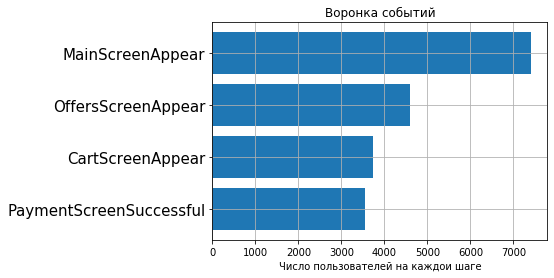

In [27]:
fig, ax = plt.subplots()

ax.barh([4,3,2,1], data_user['id_unique'])

#  Устанавливаем позиции тиков:
ax.set_yticks([4,3,2,1])

#  Устанавливаем подписи тиков
ax.set_yticklabels(data_user.index,
                   fontsize = 15)

ax.set_xlabel('Число пользователей на каждои шаге')
ax.set_title('Воронка событий')
ax.grid(True)

plt.show()

# Результаты эксперимента

[*Назад к оглавлению*](#content)

Посмотрим сколько пользователей в каждой экспериментальной группе. <a id='part_3.1'></a>

In [28]:
data_cut.groupby('experiment').agg({'id': ['nunique']})

,id
,nunique
experiment,
246,2484
247,2513
248,2537


Проверим, находят ли статистические критерии разницу между выборками 246 и 247. <a id='part_3.2'></a>

Рассмотрим доли пользователей из групп 246 и 247 (А/А тест), которые совершили покупку.

Сформулируем нулевую гипотезу: ***Доли совершивших покупку в выборках 246 и 247 одинаковы.***

Тогда альтернативная гипотеза будет звучать следующим образом: ***Доли совершивших покупку в выборках 246 и 247 различны***

In [29]:
def stat_difference(group1, group2, event):
    alpha = .05
    p1 = (data_cut.query('(experiment == @group1) & (event == @event)')['id'].nunique()/
          data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[group1,('id', 'nunique')])
    p2 = (data_cut.query('(experiment == @group2) & (event == @event)')['id'].nunique()/
          data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[group2,('id', 'nunique')])
    p_combined = ((data_cut.query('(experiment == @group1) & (event == @event)')['id'].nunique() +
                  data_cut.query('(experiment == @group2) & (event == @event)')['id'].nunique()) /
                  (data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[group1,('id', 'nunique')] + 
                   data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[group2,('id', 'nunique')]))
    
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[group1,('id', 'nunique')] + 
                                     1 / data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[group2,('id', 'nunique')]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
                  

In [30]:
stat_difference(246, 247, 'PaymentScreenSuccessful')

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим также и остальные события.

In [31]:
stat_difference(246, 247, 'MainScreenAppear')

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [32]:
stat_difference(246, 247, 'OffersScreenAppear')

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [33]:
stat_difference(246, 247, 'CartScreenAppear')

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам всех наших проверок нулевую теорию отвергнуть не удалось, то есть можно сказать, что разбиение на группы работает корректно.

Проверим, находят ли статистические критерии разницу между выборками 246 и 248. <a id='part_3.3'></a>

In [34]:
stat_difference(246, 248, 'PaymentScreenSuccessful')

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [35]:
stat_difference(246, 248, 'MainScreenAppear')

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [36]:
stat_difference(246, 248, 'OffersScreenAppear')

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [37]:
stat_difference(246, 248, 'CartScreenAppear')

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В результате проверок оказалось, что статистической значимости между группами 246 и 248 нет.

Однако стоит заметить, что если бы мы изменили порог на 0,1 (сейчас он 0,05), то по результатам последней проверки с корзиной мы бы смогли отвергнуть нулевую теорию и признали различие долей.

Проверим, находят ли статистические критерии разницу между выборками 246 и 248. <a id='part_3.4'></a>

In [38]:
stat_difference(247, 248, 'PaymentScreenSuccessful')

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
stat_difference(247, 248, 'MainScreenAppear')

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
stat_difference(247, 248, 'OffersScreenAppear')

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [41]:
stat_difference(247, 248, 'CartScreenAppear')

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В результате проверок оказалось, что статистической значимости между группами 247 и 248 нет.

Теперь результаты с объединенными группами 246 и 247.

In [42]:
def stat_difference_both(event):
    alpha = .05
    p1 = ((data_cut.query('(experiment == 246) & (event == @event)')['id'].nunique() + 
           data_cut.query('(experiment == 247) & (event == @event)')['id'].nunique())/(
          data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[246,('id', 'nunique')]+
          data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[247,('id', 'nunique')]))
    p2 = (data_cut.query('(experiment == 248) & (event == @event)')['id'].nunique()/
          data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[248,('id', 'nunique')])
    p_combined = ((data_cut.query('(experiment == 246) & (event == @event)')['id'].nunique() +
                   data_cut.query('(experiment == 247) & (event == @event)')['id'].nunique() +
                   data_cut.query('(experiment == 248) & (event == @event)')['id'].nunique()) /
                  (data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[246,('id', 'nunique')] +
                   data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[247,('id', 'nunique')] +
                   data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[248,('id', 'nunique')]))
    
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) *
                                    (1 / (data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[246,('id', 'nunique')]+
                                          data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[247,('id', 'nunique')])+ 
                                     1 / data_cut.groupby('experiment').agg({'id': ['nunique']}).loc[248,('id', 'nunique')]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [43]:
stat_difference_both('PaymentScreenSuccessful')

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [44]:
stat_difference_both('MainScreenAppear')

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [45]:
stat_difference_both('OffersScreenAppear')

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [46]:
stat_difference_both('CartScreenAppear')

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Картина не меняется - статистической значимости между группами 246+247 и 248 не

В связи с тем, что мы проводим достаточно много проверок статистических гипотез, возможно, стоит задуматься об уменьшении порога статистической значимости. Сейчас у нас принят 0,05 - это возможные ложные результаты в каждом 20 случае.
    
    
Мы сделали 16 проверок. Если бы первоначально был выбор порога статистической значимости в размере 0,1 - мы могли бы уже получить ложный результат.
    

# Вывод <a id='part_3.4'></a>

[*Назад к оглавлению*](#content)

По результатм первоначального анализа данных можно сделать следующие выводы:
1. Мы нашли 413 дублирующихся строк. Необходимо будет уточнить у коллег, действительно ли это ошибки или же особенности учета.

2. В нашем распоряжении данные с 25 июля 2019 года по 7 августа 2019 года, однако полноценные данные мы имеем только начиная с 1 августа 2019 года. Обрезав данные мы потеряли 2 828 событий и 17 уникальных пользователей, что составляет 1,16% и 0,23% от всего числа событий и пользователей соответвтенно.

3. Цепочка событий пользователя приложения следующая:
* Пользователь попадает на главный экран
* Пользователь попадает на экран с предложениями
* Пользователь попадает на экран корзины
* Успешный заказ
4. Из всей цепочки выбывается туториал. Хотя их и меньше всего, но это не потому, что до него доходят лишь те немногие, кто оформил заказ. Скорее всего, просто совсем небольшое число пользователей смотрят туториалы, так как остальные могут и так разобраться с приложением.

5. Доли пользователей, переходящих к каждому следующему событию:
* Пользователь попадает на главный экран - 100%
* Пользователь попадает на экран с предложениями - 62%
* Пользователь попадает на экран корзины - 81%
* Успешный заказ - 95%
6. Больше всего пользователей теряется при переходе от главного экрана к экрау с предложениями - 38%.

7. Почти половина пользователей (48%) все-таки оплачивает покупку.

8. По результатам всех наших проверок нулевую теорию отвергнуть не удалось, то есть можно сказать, что разбиение на группы для А/А теста (группы 246, 247) работает корректно.

9. В результате проверок оказалось, что статистической значимости между группами 246 и 248 (А/В тест) нет.

10. В результате проверок оказалось, что статистической значимости между группами 247 и 248 (А/В тест) нет.

11. Если увеличить порог статистической значимости с 0,05 до 0,1, то между группами 246 и 248 по результатам проверки с долей пользователей попавших на страницу корзины мы бы смогли отвергнуть нулевую теорию и признали различие долей. Однако исходя из того, что мы проводили большое число проверок, это могло бы привести к ложному результату.

12. В результате проверок оказалось, что статистической значимости между группами 246+247 и 248 (А/В тест) нет.


В результате нашего анализа можно сказать, что разницы, какой выбирать шрифт, нет - пользователи одинаково взаимодействуют с приложением.